In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np


class PolicyNetwork(nn.Module):
    """Actor-Critic网络"""
    def __init__(self, state_dim, action_dim):
        super().__init__()
        # 共享特征提取
        self.shared = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.LayerNorm(128),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.LayerNorm(64)
        )
        
        # 策略头
        self.policy_head = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, action_dim),
            nn.Softmax(dim=-1)
        )
        
        # 价值头
        self.value_head = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        features = self.shared(x)
        return self.policy_head(features), self.value_head(features)


class A2CAgent():
    """调整过的A2C智能体"""
    def __init__(self, env, gamma=0.99, lr=3e-4, n_steps=5, entropy_coef=0.05):
        self.env = env
        self.gamma = gamma
        self.n_steps = n_steps
        self.initial_entropy_coef = entropy_coef
        
        # 简化的状态表示维度
        self.state_dim = 4  # [row, col, rel_col, rel_row]
        
        # 创建网络
        self.model = PolicyNetwork(self.state_dim, len(env.action_space))
        self.optimizer = optim.Adam(
            self.model.parameters(), 
            lr=lr, 
            weight_decay=1e-4  # 添加权重正则化
        )
        
        # 学习率调度器
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, 
            mode='max',  # 监控奖励
            factor=0.5,
            patience=50,
            min_lr=1e-5,
            verbose=True
        )
        
        # 训练日志
        self.rewards_history = []
        self.steps_history = []
        self.loss_history = []
        self.entropy_coef_history = []
    
    def state_representation(self, state):
        """简化的状态表示"""
        row, col = state
        goal_row, goal_col = self.env.goal_state
        
        return torch.tensor([
            row / self.env.height,  # 归一化行坐标
            col / self.env.width,   # 归一化列坐标
            (col - goal_col) / self.env.width,  # 水平相对位置
            (row - goal_row) / self.env.height  # 垂直相对位置
        ], dtype=torch.float32)
    
    def compute_returns(self, rewards, next_state, done):
        """计算折扣回报"""
        next_state_rep = self.state_representation(next_state)
        with torch.no_grad():
            _, next_value = self.model(next_state_rep.unsqueeze(0))
            next_value = next_value.item()
        
        returns = []
        R = next_value if not done else 0
        for r in reversed(rewards):
            R = r + self.gamma * R
            returns.insert(0, R)
        return returns
    
    def get_action(self, state):
        """根据当前状态选择动作"""
        state_rep = self.state_representation(state)
        action_probs, _ = self.model(state_rep.unsqueeze(0))
        
        # 从概率分布中采样动作
        dist = Categorical(action_probs)
        action = dist.sample()
        
        return action.item(), dist.log_prob(action)
    
    def get_greedy_action(self, state):
        """获取贪婪策略下的动作（用于评估）"""
        state_rep = self.state_representation(state)
        action_probs, _ = self.model(state_rep.unsqueeze(0))
        return torch.argmax(action_probs).item()
    
    def update(self, states, actions, log_probs, rewards, values, masks):
        """更新网络参数"""
        returns = self.compute_returns(rewards, states[-1], masks[-1])
        returns = torch.tensor(returns, dtype=torch.float32)
        
        # 计算优势函数
        values = torch.tensor(values, dtype=torch.float32)
        advantages = returns - values
        
        # 计算损失
        actor_loss = -(log_probs * advantages.detach()).mean()
        critic_loss = F.mse_loss(values, returns)
        
        # 计算策略熵
        entropy = -(log_probs.exp() * log_probs).mean()
        
        # 动态熵系数（随训练衰减）
        # entropy_coef = max(0.001, self.initial_entropy_coef * (1.0 - len(self.rewards_history)/4000))
        
        # 改为指数衰减
        entropy_coef = max(0.001, self.initial_entropy_coef * 0.9999**len(self.rewards_history))

        # 总损失
        total_loss = actor_loss + 0.5 * critic_loss - entropy_coef * entropy
        
        # 梯度更新
        self.optimizer.zero_grad()
        total_loss.backward()
        
        # 梯度裁剪（防止梯度爆炸）
        nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=0.5)
        
        self.optimizer.step()
        
        return total_loss.item(), entropy_coef
    
    def get_policy(self):
        """获取学习到的策略"""
        greedy_policy = {}  # 状态到最优动作的映射
        prob_policy = {}    # 状态到动作概率分布的映射（用于渲染）
        
        for state in self.env.states():
            if state not in self.env.wall_state:  # 跳过墙状态
                state_rep = self.state_representation(state)
                state_tensor = torch.FloatTensor(state_rep).unsqueeze(0)
                action_probs, _ = self.model(state_tensor)
                action_probs = action_probs.detach().squeeze().numpy()
                
                # 找到概率最高的动作
                best_action = np.argmax(action_probs)
                
                # 保存最优动作
                greedy_policy[state] = best_action
                
                # 保存动作概率分布（用于渲染）
                probs = {action: float(action_probs[action]) for action in range(len(self.env.action_space))}
                prob_policy[state] = probs
        
        return greedy_policy, prob_policy

    def test_policy(self, num_tests=1000, max_steps=300):
        """测试A2C策略的性能"""
        steps_count = []
        success_count = 0
        
        for i in range(num_tests):
            state = self.env.reset()
            done = False
            step_count = 0
            
            while not done and step_count < max_steps:
                # 使用贪婪策略选择动作
                action = self.get_greedy_action(state)
                
                # 执行动作
                next_state, reward, done = self.env.step(action)
                
                # 更新状态
                state = next_state
                step_count += 1
                
                # 检查是否成功到达目标
                if done and state == self.env.goal_state:
                    success_count += 1
                    steps_count.append(step_count)
                    break
                elif done and state != self.env.goal_state:
                    # 落入陷阱或撞墙
                    break
            else:
                # 达到最大步数但未完成
                pass
        
        # 计算成功率
        success_rate = success_count / num_tests
        
        # 计算平均步数（仅成功回合）
        avg_steps = np.mean(steps_count) if steps_count else 0
        
        print(f"\nA2C Policy Test Results:")
        print(f"Success Rate: {success_rate:.2%}")
        print(f"Average Steps (successful episodes): {avg_steps:.2f}")
        print(f"Total Tests: {num_tests}, Successful: {success_count}")
        
        return success_rate, avg_steps


Episode  200, Reward:   0.02, Avg Reward (200):  -0.04, Steps: 300, Loss: 0.0003, Entropy Coef: 0.0475
Episode  400, Reward:   0.02, Avg Reward (200):  -0.23, Steps: 300, Loss: -0.0006, Entropy Coef: 0.0450
添加惩罚状态(12, 16): -1.0
Episode  600, Reward:   0.03, Avg Reward (200):  -0.14, Steps: 300, Loss: -0.0002, Entropy Coef: 0.0425
Episode  800, Reward:   2.03, Avg Reward (200):  -0.12, Steps: 287, Loss: 0.1039, Entropy Coef: 0.0400
Episode 1000, Reward:   0.01, Avg Reward (200):  -0.23, Steps: 300, Loss: 0.0001, Entropy Coef: 0.0375
Episode 1200, Reward:   0.01, Avg Reward (200):  -0.28, Steps: 300, Loss: 0.0009, Entropy Coef: 0.0350
Episode 1400, Reward:   0.03, Avg Reward (200):  -0.36, Steps: 300, Loss: 0.0010, Entropy Coef: 0.0325
Episode 1600, Reward:   0.02, Avg Reward (200):  -0.28, Steps: 300, Loss: 0.0015, Entropy Coef: 0.0300
Episode 1800, Reward:   0.02, Avg Reward (200):  -0.23, Steps: 300, Loss: 0.0016, Entropy Coef: 0.0275
Episode 2000, Reward:   0.00, Avg Reward (200):  -

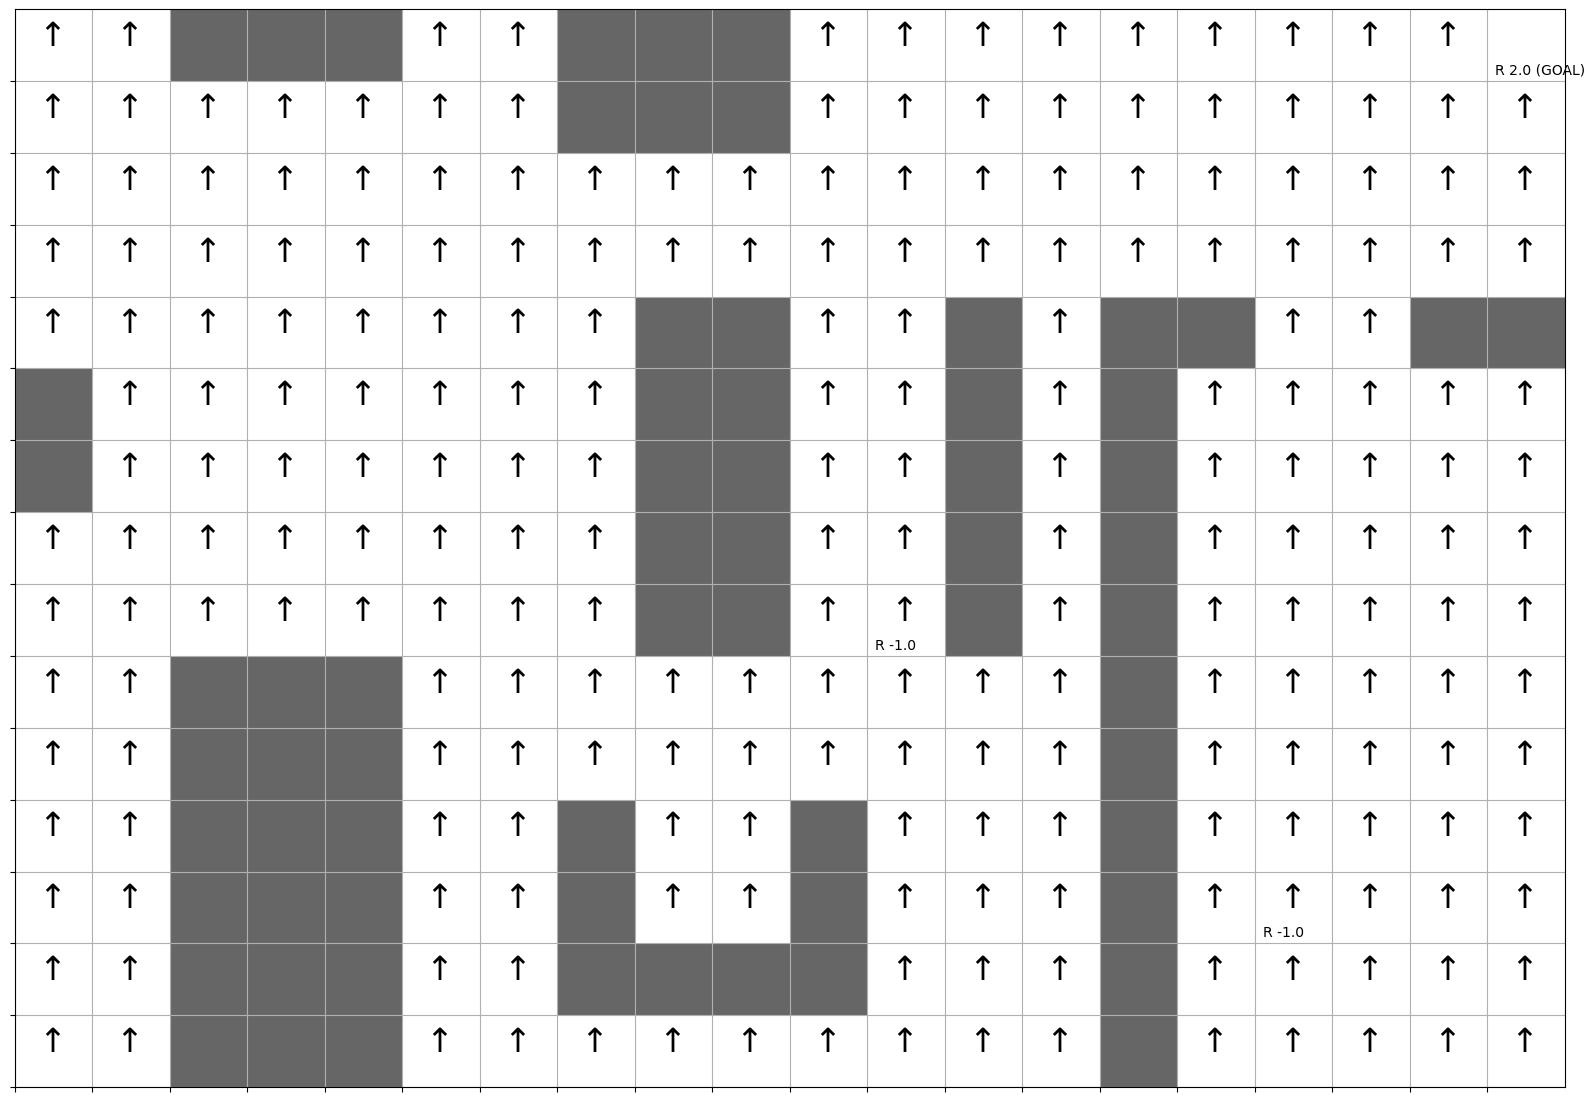

In [14]:
import os
import sys
import time

# 确保能够导入环境
if "common_expand" not in sys.path:
    sys.path.append(os.path.join(os.getcwd(), "common_expand"))

from common_expand.gridworld import GridWorld

# 创建环境
env = GridWorld()

# 创建智能体
agent = A2CAgent(env, gamma=0.99, lr=3e-4, n_steps=5, entropy_coef=0.05)

# 主训练函数
episodes = 2000
log_interval = 200
max_steps_per_episode = 300

# 保存目录
data_root = "./data_A2C_1"   
# 确保保存目录存在
os.makedirs(data_root, exist_ok=True)
training_data_file = os.path.join(data_root, "a2c_train_data.csv")

# 初始化训练数据文件
with open(training_data_file, "w") as f:
    f.write("episode,total_reward,step_count,loss,entropy_coef\n")

start_time = time.time()

for episode in range(1, episodes + 1):
    state = env.reset()
    done = False
    total_reward = 0
    step_count = 0
    episode_loss = 0
    update_count = 0
    
    # 初始化轨迹数据
    states, actions, log_probs, rewards, values, masks = [], [], [], [], [], []
    
    while not done and step_count < max_steps_per_episode:
        # 选择动作
        action, log_prob = agent.get_action(state)
        
        # 执行动作
        next_state, reward, done = env.step(action)
        
        # 改进的奖励塑形：基于距离目标的缩短（系数减小）
        goal = env.goal_state
        prev_dist = abs(state[0] - goal[0]) + abs(state[1] - goal[1])
        next_dist = abs(next_state[0] - goal[0]) + abs(next_state[1] - goal[1])
        reward += 0.001 * (prev_dist - next_dist)  # 系数从0.01减小到0.001
        
        # # 添加陷阱惩罚
        # if next_state in env.pit_states:
        #     reward -= 0.5
        
        # 存储转移
        state_rep = agent.state_representation(state)
        _, state_value = agent.model(state_rep.unsqueeze(0))
        state_value = state_value.item()
        
        states.append(state)
        actions.append(action)
        log_probs.append(log_prob)
        rewards.append(reward)
        values.append(state_value)
        masks.append(done)
        
        # 更新状态
        state = next_state
        total_reward += reward
        step_count += 1
        
        # N步更新
        if len(states) >= agent.n_steps or done:
            loss, entropy_coef = agent.update(
                states, actions, torch.stack(log_probs), rewards, values, masks
            )
            
            # 记录损失
            episode_loss += loss
            update_count += 1
            
            # 记录熵系数
            agent.entropy_coef_history.append(entropy_coef)
            
            # 清空缓冲区
            states, actions, log_probs, rewards, values, masks = [], [], [], [], [], []
    
    # 计算平均损失
    avg_loss = episode_loss / update_count if update_count > 0 else 0

    if episode == 500:
        print("添加惩罚状态(12, 16): -1.0")
        env.add_pits((12, 16))
        agent.env.add_pits((12, 16))
    
    # 记录回合数据
    agent.rewards_history.append(total_reward)
    agent.steps_history.append(step_count)
    agent.loss_history.append(avg_loss)
    
    # 动态调整熵系数
    current_entropy_coef = max(0.001, 0.05 * (1.0 - episode / 4000))
    
    # 更新学习率（基于最近100回合的平均奖励）
    if len(agent.rewards_history) > 100:
        avg_reward = np.mean(agent.rewards_history[-100:])
        agent.scheduler.step(avg_reward)
    
    # 保存训练数据
    with open(training_data_file, "a") as f:
        f.write(f"{episode},{total_reward},{step_count},{avg_loss},{current_entropy_coef}\n")
    
    # 打印训练进度
    if episode % log_interval == 0:
        avg_reward = np.mean(agent.rewards_history[-log_interval:])
        print(f"Episode {episode:4d}, Reward: {total_reward:6.2f}, "
                f"Avg Reward ({log_interval}): {avg_reward:6.2f}, Steps: {step_count}, "
                f"Loss: {avg_loss:.4f}, Entropy Coef: {current_entropy_coef:.4f}")
    
    # 保存模型
    model_path = os.path.join(data_root, "a2c_gridworld_model_final.pth")
    torch.save({
        'model_state_dict': agent.model.state_dict(),
        'optimizer_state_dict': agent.optimizer.state_dict(),
        'entropy_coef': current_entropy_coef,
        'episode': episode
    }, model_path)


duration = time.time() - start_time
print(f"A2C training completed in {duration:.2f} seconds")

# 测试策略
success_rate, avg_steps = agent.test_policy(num_tests=1000)
print(f"Final Test Success Rate: {success_rate:.2%}, Avg Steps: {avg_steps:.2f}")

# 可视化策略
greedy_policy, prob_policy = agent.get_policy()
    
print("\nA2C Learned Policy (State -> Best Action):")
for state, best_action in greedy_policy.items():
    print(f"State: {state}, Best Action: {best_action}")

print("\nA2C Learned Policy Visualization:")
env.render_v(None, prob_policy)

In [15]:
from matplotlib import pyplot as plt


"""可视化训练结果"""
os.makedirs(data_root, exist_ok=True)

# 奖励曲线
plt.figure(figsize=(12, 6))
plt.plot(agent.rewards_history)
plt.title('A2C - Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.grid(True)
plt.savefig(os.path.join(data_root, "a2c_rewards.png"))
plt.close()

# 每回合步数
plt.figure(figsize=(12, 6))
plt.plot(agent.steps_history)
plt.title('A2C - Steps per Episode')
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.grid(True)
plt.savefig(os.path.join(data_root, "a2c_steps.png"))
plt.close()

# 损失曲线
if agent.loss_history:
    plt.figure(figsize=(12, 6))
    plt.plot(agent.loss_history)
    plt.title('A2C - Training Loss per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.savefig(os.path.join(data_root, "a2c_loss.png"))
    plt.close()

# 熵系数曲线
if agent.entropy_coef_history:
    plt.figure(figsize=(12, 6))
    plt.plot(agent.entropy_coef_history)
    plt.title('A2C - Entropy Coefficient per Update')
    plt.xlabel('Update')
    plt.ylabel('Entropy Coefficient')
    plt.grid(True)
    plt.savefig(os.path.join(data_root, "a2c_entropy_coef.png"))
    plt.close()


In [ ]:
# 载入模型
model = A2C()
model.load_state_dict(torch.load('a2c_model.pth'))
model.eval()